In [1]:
import pandas as pd

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

import os
import sys
from contextlib import contextmanager

In [2]:
script_path = os.getcwd()
src_path = r"./Data/Cleaned data"

categorical_features = ["sex", "restecg", "slope", "cp"]
integer_features = ["age", "trestbps", "chol", "thalach"]
float_features = ["oldpeak"]
boolean_features = ["fbs", "exang"]

scores = ["accuracy", "precision", "recall", "f1"]

seed = 1234

In [3]:
def set_dtypes(df):
    for column in df.columns:
        if column in categorical_features:
            df[column] = df[column].astype("category", copy=False)
        elif column in boolean_features:
            df[column] = df[column].astype("Int64", copy=False)
        elif column in float_features:
            df[column] = pd.to_numeric(df[column], downcast="float", errors="coerce")
        elif column in integer_features:
            df[column] = pd.to_numeric(df[column], downcast="float", errors="coerce")
            df[column] = df[column].astype("Int64", copy=False)
    return df

In [4]:
@contextmanager
def gen_list(file_path):
    f = os.chdir(file_path)
    yield f
    os.chdir(script_path)
    
with gen_list(src_path) as f:
    df = pd.read_csv(r"cleaned_processed_cleveland.csv")
    df1 = pd.read_csv(r"cleaned_processed_hungarian.csv")
    df2 = pd.read_csv(r"cleaned_processed_switzerland.csv")
    df3 = pd.read_csv(r"cleaned_processed_va.csv")

df_y = df["num"]

df_y.replace([2, 3, 4], 1, inplace=True)

df.drop("num", axis=1, inplace=True)
df.drop("thal", axis=1, inplace=True)
df.drop("ca", axis=1, inplace=True)

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,63,1.0,1.0,145,233,1,2.0,150,0,2.3,3.0
1,67,1.0,4.0,160,286,0,2.0,108,1,1.5,2.0
2,67,1.0,4.0,120,229,0,2.0,129,1,2.6,2.0
3,37,1.0,3.0,130,250,0,0.0,187,0,3.5,3.0
4,41,0.0,2.0,130,204,0,2.0,172,0,1.4,1.0


In [5]:
eval_df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

eval_y = eval_df["num"]
eval_y.replace([2, 3, 4], 1, inplace=True)

eval_df.drop("num", axis=1, inplace=True)
eval_df.drop("thal", axis=1, inplace=True)
eval_df.drop("ca", axis=1, inplace=True)

In [6]:
eval_df.shape

(617, 11)

In [7]:
eval_df.shape

(617, 11)

In [8]:
df_y.head()

0    0
1    1
2    1
3    0
4    0
Name: num, dtype: int64

In [9]:
df.dtypes

age           int64
sex         float64
cp          float64
trestbps      int64
chol          int64
fbs           int64
restecg     float64
thalach       int64
exang         int64
oldpeak     float64
slope       float64
dtype: object

In [10]:
df = set_dtypes(df)

df.dtypes

age            Int64
sex         category
cp          category
trestbps       Int64
chol           Int64
fbs            Int64
restecg     category
thalach        Int64
exang          Int64
oldpeak      float32
slope       category
dtype: object

In [11]:
cat_pipe = Pipeline([("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
                    ("impute", KNNImputer())])

num_pipe = Pipeline([("scaling", MaxAbsScaler()),
                    ("imputing", KNNImputer())])

preprocessor = ColumnTransformer([("categorical features", cat_pipe, categorical_features),
                                 ("numerical features", num_pipe, integer_features+float_features+boolean_features)])

mlp_pipe = Pipeline([("preprocessing", preprocessor),
                    ("clf", MLPClassifier())])

In [12]:
train_x, test_x, train_y, test_y = train_test_split(df, df_y, test_size=0.1, random_state=seed, stratify=df_y)

In [13]:
grid_param = {
    "clf__hidden_layer_sizes": [(100),
                                (500),
                                (1000),
                                (100, 100),
                                (500, 500),
                                (1000, 1000),
                                (100, 100, 100),
                                (500, 500, 500),
                                (1000, 1000, 1000),
                                (100, 100, 100, 100),
                                (500, 500, 500, 500),
                                (1000, 1000, 1000, 1000)],
    "clf__max_iter": [2000, 2500, 3000]
}

In [14]:
mlp_clf = GridSearchCV(mlp_pipe, grid_param, cv=5, scoring="accuracy", n_jobs=-1, refit=True)

mlp_clf.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('categorical '
                                                                         'features',
                                                                         Pipeline(steps=[('encoding',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('impute',
                                                                                          KNNImputer())]),
                                                                         ['sex',
                                                                          'restecg',
                           

In [15]:
pred = mlp_clf.predict(test_x)

In [16]:
fin_dict = {
    "Accuracy": [accuracy_score(pred, test_y)],
    "Precision": [precision_score(pred, test_y)],
    "Recall": [recall_score(pred, test_y)],
    "F1": [f1_score(pred, test_y)]
}

results = pd.DataFrame(fin_dict)

results

,Accuracy,Precision,Recall,F1
0,0.774194,0.785714,0.733333,0.758621


In [17]:
mlp_clf.best_params_

{'clf__hidden_layer_sizes': (1000, 1000, 1000), 'clf__max_iter': 2500}

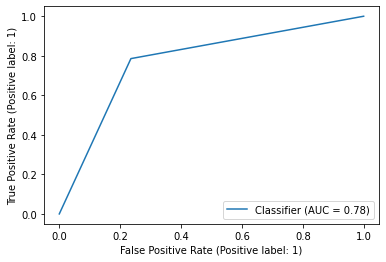

In [18]:
RocCurveDisplay.from_predictions(test_y, pred)

In [19]:
eval_df = pd.DataFrame(set_dtypes(eval_df))

In [20]:
eval_df.shape

(617, 11)

In [21]:
eval_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,28,1,2,130,132,0,2.0,185,0,0.0,NaN
1,29,1,2,120,243,0,0.0,160,0,0.0,NaN
2,29,1,2,140,<NA>,0,0.0,170,0,0.0,NaN
3,30,0,1,170,237,0,1.0,170,0,0.0,NaN
4,31,0,2,100,219,0,1.0,150,0,0.0,NaN


In [22]:
optimised_clf = mlp_clf.best_estimator_

eval_pred = optimised_clf.predict(eval_df)

eval_dict = {
    "Accuracy": [accuracy_score(eval_pred, eval_y)],
    "Precision": [precision_score(eval_pred, eval_y)],
    "Recall": [recall_score(eval_pred, eval_y)],
    "F1": [f1_score(eval_pred, eval_y)]
}

eval_results = pd.DataFrame(eval_dict)

eval_results

,Accuracy,Precision,Recall,F1
0,0.672609,0.683784,0.748521,0.714689
